**Hello, world!**

Welcome to my first-ever post on my personal website! A quick intro about myself: I'm Chelsea, and I am a data-enthusiast and an aspiring data scientist basedin Toronto, Canada. I graduated from McGill University, where I jointly studied Physiology and Math during my undergrad and Computational Neuroscience for a Master's degree. And for the past couple of months, I have been trying to practice with more data analysis and ML techniques in the hopes that I can become a data scientist one day. In the meantime, I'll be sharing my journey here on my personal website -- I hope you'll join me if you'd like!

In this post, I'll be running through an exploratory data analysis I've done on publicly-available data of clinical trials being conducted worldwide. The data I used here was originally uploaded on [Kaggle](https://www.kaggle.com/parulpandey/covid19-clinical-trials-dataset). Please note that the `markdown`-converted version of this `jupyter notebook` documentation will not contain the full code that was used to conduct my analyses; for the full version, please see [my github repo](https://github.com/chels-kim/kaggle-covid-clintri)!

---

# Contents

1. [Higher-level analysis of data](#1.-Higher-level-analysis-of-data)
2. [Brainstorming questions I'd like to ask](#2.-Brainstorming-questions-I'd-like-to-ask)
3. [Exploratory data analysis](#3.-Exploratory-analysis)  
    i. [Comparison of COVID-related vs -unrelated studies](#3.1.-Comparison-of-COVID-related-vs.-unrelated-studies)  
    ii. [A deeper dive into COVID-related studies](#3.2.-A-deeper-dive-into-covid-related-studies)

---

Before we get started, here's an overview of what I hope to accomplish in each seciton laid out above.

## Plan of Attack

In my higher-level analysis of the dataset, I'll be taking notes on the author's descriptions on Kaggle. I might also check out the [associated notebook](https://www.kaggle.com/parulpandey/eda-on-covid-19-clinical-trials) to get a better sense of the data. Following this general overview of the dataset, I'll be organizing my questions and brainstorming the analyses that I'm inspired to carry out. By the end of this, I'll have a better idea of what steps I will take throughout the EDA.

After this -- you guessed it -- the EDA itself! Everything leading up to this will have been in preparation for this step. This is where most of my more in-depth analyses will take place. Since I have not much experience with some tools and techniques that I'll be using, my technical goals specifically for this EDA are:
- get more comfortable working with the basic packages like Numpy and Pandas.
- get used to graphing using matplotlib library since that's the most common one.
    
Alright, let's get started!


# 1. Higher-level analysis of data

## Some quick notes on the data

Maintained by the NIH, the database at [ClinicalTrials.gov](ClinicalTrials.gov) contains information about all privately and publicly funded clinical studies around the world. The particular dataset to be used consists of clinical trials related to COVID-19 studies specifically. The authors note the following about their dataset:  
 - XML files: each corresponds to one study; filename is formatted as `NCT########.xml`, where the `#`'s indicate unique numerical identifiers of studies.
 - 1 CSV file: not as detailed as above but provides a summary.
    
Let's see what the data look like.

In [1]:
# Importing relevant modules

# libraries
import pandas as pd
import numpy as np
import os
from xml.etree import ElementTree
import scipy.stats as stats
import datetime

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# Read file data
current_folder = os.path.dirname(os.path.realpath('__file__'))
xml_path = os.path.join(current_folder, 'covid19-clinical-trials-dataset',
                        'COVID-19 CLinical trials studies', 'COVID-19 CLinical trials studies')

list_of_files = os.listdir(xml_path)
print('Total number of clinical trials:', len(list_of_files))

Total number of clinical trials: 5020


That's a lot of clinical trials! And, from what I can see, this is not the complete set of trials available on the website. Since we have a lot of files to deal with, it'll probably be best to extract only relevant information into a Pandas dataframe and work with that throughout the analysis.

In [2]:
# .xml files to pandas dataframe, and save as .csv for future use.
# If already existing, load file

df_studies_pathname = os.path.join(current_folder, 'studies_summarized.csv')

if os.path.isfile(df_studies_pathname):
    # If already saved, load the csv file
    df_studies = pd.read_csv(current_folder + '/studies_summarized.csv')

else:
    # .xml to pandas dataframe.
    # for most of this part I will be copying the referencing the original notebook's code,
    # because I'm not focused on learning how to do this for now.

    df_studies = pd.DataFrame()
    list_keywords = []

    for file in list_of_files:
        file_pathname = os.path.join(xml_path, file)

        tree = ElementTree.parse(file_pathname)
        root = tree.getroot()

        # create dictionary to be turned into a df
        trial = {}

        trial['id'] = root.find('id_info').find('nct_id').text
        trial['overall_status'] = root.find('overall_status').text
        trial['study_type'] = root.find('study_type').text

        if root.find('start_date') != None:
            trial['start_date'] = root.find('start_date').text
        else:
            trial['start_date'] = ''

        if root.find('enrollment') != None:
            trial['enrollment'] = root.find('enrollment').text
        else:
            trial['enrollment'] = ''

        # modified below to output all conditions being studied, not just the first condition listed
        l_cond = []
        for cond in root.findall('condition'):
            entry = cond.text.upper().\
                replace('CORONAVIRUS INFECTIONS','CORONAVIRUS INFECTION').\
                replace('CORONA VIRUS INFECTION','CORONAVIRUS INFECTION').\
                replace('SARS-COV-2','SARS-CoV2').\
                replace('SARS-COV 2','SARS-CoV2').\
                replace('SARS-COV2','SARS-CoV2').\
                replace('COVID-19','COVID').\
                replace('COVID19','COVID').\
                replace('COVID 19','COVID')
            l_cond.append(entry)
        trial['conditions'] = '; '.join(l_cond)

        if root.find('location_countries') != None:
            trial['location_countries'] = root.find('location_countries').find('country').text.upper()
        else:
            trial['location_countries'] = ''

        # also modified below to find all interventions used
        l_inter = []
        if root.findall('intervention') != None:
            for inter in root.findall('intervention'):
                inter_entry = inter.find('intervention_name').text.upper()
                l_inter.append(inter_entry)
            trial['intervention'] = '; '.join(l_inter)
        else:
            trial['intervention'] = ''

        for entry in root.findall('keyword'):
            list_keywords.append(entry.text)

        if root.find('official_title') == None:
            trial['title'] = root.find('brief_title').text
        else:
            trial['title'] = root.find('official_title').text
        
        trial['brief_title'] = root.find('brief_title').text

        date_string = root.find('required_header').find('download_date').text
        trial['date_processed'] = date_string.replace('ClinicalTrials.gov processed this data on ', '')

        trial['sponsors'] = root.find('sponsors').find('lead_sponsor').find('agency').text

        df_studies = df_studies.append(trial, ignore_index=True)

    # save as a csv file
    df_studies.to_csv(df_studies_pathname)

In [3]:
# file loaded in a hidden cell above.

# print the first three rows of studies dataframe
df_studies.head(3)

,Unnamed: 0,brief_title,conditions,date_processed,enrollment,id,intervention,location_countries,overall_status,sponsors,start_date,study_type,title
0,0,Isolation and Culture of Immune Cells and Circ...,"SOLID TUMOR, ADULT; HEALTHY DONORS; COVID DONORS","February 08, 2021",1000.0,NCT00571389,NaN,UNITED STATES,Recruiting,"BioCytics, Inc.",November 2007,Observational,A Study to Facilitate Development of an Ex-Viv...
1,1,Collection of Human Samples to Study Hairy Cel...,HAIRY CELL LEUKEMIA (HCL); CHRONIC LYMPHOCYTIC...,"February 08, 2021",1263.0,NCT01087333,NaN,UNITED STATES,Recruiting,National Cancer Institute (NCI),"March 2, 2010",Observational,Collection of Human Samples to Study Hairy Cel...
2,2,Ethnic Differences in the Impact of Breast Can...,BREAST CANCER,"February 08, 2021",935.0,NCT01134172,SURVEY WEB-BASED OR TELEPHONE INTERVIEW; SURVE...,UNITED STATES,"Active, not recruiting",Memorial Sloan Kettering Cancer Center,May 2010,Observational,Breast Cancer and the Workforce: Ethnic Differ...


Hold on -- did I read that right? I thought this dataset only contained COVID-19-related studies, yet looking at the `conditions` column tells me that some of the conditions may not entirely be related to COVID-19. Perhaps this means that later on, I'll have to do more sophisticated categorization of studies. Let me take a better look at the conditions and titles of studies.

In [4]:
pd.set_option('display.max_colwidth', None)
df_studies[['conditions','title']].head(10)

,conditions,title
0,"SOLID TUMOR, ADULT; HEALTHY DONORS; COVID DONORS","A Study to Facilitate Development of an Ex-Vivo Device Platform for Circulating Tumor Cell and Immune Cell Harvesting, Banking, and Apoptosis-Viability Assay"
1,HAIRY CELL LEUKEMIA (HCL); CHRONIC LYMPHOCYTIC LEUKEMIA (CLL); NON-HODGKINS LYMPHOMA (NHL); CUTANEOUS T CELL LYMPHOMA (CTCL); ADULT T CELL LYMPHOMA (ATL),Collection of Human Samples to Study Hairy Cell and Other Leukemias and to Develop Recombinant Immunotoxins for Cancer Treatment
2,BREAST CANCER,"Breast Cancer and the Workforce: Ethnic Differences in the Impact of Breast Cancer on Employment Status, Financial Situation, and Quality of Life (BCW)"
3,ANOGENITAL HERPES; COVID; HERPES LABIALIS,Viral Infections in Healthy and Immunocompromised Hosts
4,HIV-1 INFECTION,A Randomized Comparison of Three Regimens of Chemotherapy With Compatible Antiretroviral Therapy for Treatment of Advanced AIDS-KS in Resource-Limited Settings
5,CANCER PATIENTS,Food: A Three-Arm Randomized Controlled Study Examining Food Insecurity Interventions
6,COMPLICATIONS; CESAREAN SECTION,Vaginal Cleansing Before Cesarean Delivery to Reduce Infection: A Randomized Trial
7,COMMUNITY ACQUIRED PNEUMONIA,Effects of Low-dose Corticosteroids on Survival of Severe Community-acquired Pneumonia
8,HYPERTROPHIC CARDIOMYOPATHY; LONG QT SYNDROME,"Exercise in Genetic Cardiovascular Conditions (Lifestyle and Exercise in Hypertrophic Cardiomyopathy ""LIVE-HCM""/Lifestyle and Exercise in the Long QT Syndrome ""LIVE-LQTS"""
9,UVEITIS,Uveitis/Intraocular Inflammatory Disease Biobank (iBank)


Indeed, not all studies seem related to COVID-19; in fact, only the first and fourth entries mention the word "COVID" at all in the `conditions` column . So why were the rest of them that do not study COVID as a condition included in this dataset? To find out, I will randomly select one of the 8 seemingly COVID-irrelevant studies above, and print its brief summary.

In [5]:
pd.reset_option('display.max_colwidth')

sus_id = df_studies.loc[df_studies.conditions == 'CANCER PATIENTS', 'id'].iloc[0]
root = ElementTree.parse(os.path.join(xml_path, sus_id + '.xml')).getroot()
summary = root.find('brief_summary').find('textblock').text

print('This is the brief summary of study #' + sus_id + ', titled "' + df_studies.title.iloc[5] + '":')
print(summary)

This is the brief summary of study #NCT01603316, titled "Food: A Three-Arm Randomized Controlled Study Examining Food Insecurity Interventions":

      The investigators have found that many patients getting treatment for cancer have trouble
      getting enough to eat, or do not always have enough money for food. When a patient has these
      problems it can lead to difficulties with completing cancer treatment. Across New York City,
      there are many hospitals that offer their patients food pantry services on location. The
      investigators would like to compare how food pantries within the hospital and two other food
      assistance options: monthly food vouchers and weekly grocery deliveries maybe possible
      solutions to this problem. The patient will be randomly assigned to one of the three
      different food program groups, which means everyone has an equal chance in being in any
      group, like a flip of a coin. The investigators hope to learn how to best help pat

Clearly, the focus of this study appears to be nothing related to the medical conditions associated with COVID-19; rather, it is a study investigating food insecurity in cancer patients and its impact on cancer treatment. In fact, a closer look at the original .xml file reveals where COVID-19 was mentioned at all within the study description:

In [6]:
int_description = root.find('intervention').find('description').text
print('Intervention description: \n\n' + int_description)

Intervention description: 

Each survey will take about 45 minutes.Surveys will include questions on medical treatment, health insurance, work-related information, overall health and well being, eating habits, and satisfaction/use of the food program provided. 3 and 6-month follow-up. All participants will be asked to complete the study contact form. Need Assessment surveys will be administered via telephone or in person. The content of the needs assessment questionnaire has been informed by themes generated through IHCD's ongoing research and community outreach and service activities with the cancer patient population at our participating institutions. The survey will ask participants about the impact on their cancer care and their socioeconomic needs of the COVID-19 crisis.


In this description of intervention used in the study, COVID-19 is briefly mentioned in the last sentence as one of the questions to be asked to participants in the survey. Considering the previous summary of the study and how the above paragraph was the only instance where COVID-19 was mentioned by the authors of the study, we can conclude that the study itself is *not* concerned with the SARS-CoV-2 virus, COVID-19, or the physiological complications arising from it. Thus, it's hard to say that this study is one of the "COVID-19 clinical trials" as the dataset is titled.

From this preliminary analysis, I realize that it might be useful for me to first sort through the dataset in the beginning of my EDA, distinguishing studies that do investigate the symptoms, immunological/respiratory effects, or the nature of SARS-CoV-2 virus / COVID-19, from those that do not.

Cool, now we can move onto loading the .csv file as well, which should contain summaries of the .xml files.

In [7]:
# Load the CSV file as well
df_studies_CSV = pd.read_csv( os.path.join(current_folder, 'covid19-clinical-trials-dataset',
                                           'COVID clinical trials.csv'))
df_studies_CSV.head(3)

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
1,2,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
2,3,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061


In [8]:
# What's in the CSV that's not listed in the XML data? Or at least lost in translation to dfs?
print(df_studies.columns)
print(df_studies_CSV.columns)

Index(['Unnamed: 0', 'brief_title', 'conditions', 'date_processed',
       'enrollment', 'id', 'intervention', 'location_countries',
       'overall_status', 'sponsors', 'start_date', 'study_type', 'title'],
      dtype='object')
Index(['Rank', 'NCT Number', 'Title', 'Acronym', 'Status', 'Study Results',
       'Conditions', 'Interventions', 'Outcome Measures',
       'Sponsor/Collaborators', 'Gender', 'Age', 'Phases', 'Enrollment',
       'Funded Bys', 'Study Type', 'Study Designs', 'Other IDs', 'Start Date',
       'Primary Completion Date', 'Completion Date', 'First Posted',
       'Results First Posted', 'Last Update Posted', 'Locations',
       'Study Documents', 'URL'],
      dtype='object')


Because we extracted only a few important categories of information from the .xml files, the `df_studies` dataframe is more condensed than the .csv file's summary in `df_studies_CSV`.

And with that, I can finally move on to the next step in the EDA: brainstorming questions.

# 2. Brainstorming questions I'd like to ask

In the surface-level analysis of the given dataset, I found that it contains information about some studies that are unrelated to COVID-19. For the sake of brevity, I will be labelling studies related and unrelated to COVID-19 as "COVID-related" and "Unrelated" studies, respectively. With that in mind, here are some questions I would like to ask throughout the analysis:

1. Regarding the entire dataset:
    - What are the conditions that are being studied (in COVID-related and unrelated studies)?
    - What status is each study in? Which of those are COVID-related?
        - From the CSV file column description in original dataset post, there is a very small number of studies with results available (1%). What percentage is this of the actual studies that have already been completed?
    - In which countries do studies take place? Which of those are COVID-related?
    - What are the study types used? Do COVID-related studies differ from the rest?
        - What's the distribution of enrollment sizes for study types?
  

2. In COVID-related studies:
    - Specific to **observational studies**:
        - length of each study (from CSV)
        - how is the outcome measured?
    - Specific to **interventional studies**:
        - length of each study (also from CSV)
        - what were some types of interventions used?
        - in drug studies, what were the top 5 most popular ones studied?
    - In the small percentage of studies that actually have results posted, were any of them focused on COVID?
        - If so, can we draw any meaningful conclusions?



# 3. Exploratory analysis

## 3.1. Comparison of COVID-related vs. unrelated studies

### Conditions being studied

First, I want to categorize the conditions being studied; mainly, are they related to COVID-19 or not? If they are not, then could they still be studying related viruses, such as similar respiratory infections? To find out, I will first parse through the `conditions` column of the `df_studies` dataframe. In doing so, I will break them down into three categories: `COVID-related`, `Respiratory`, and `Unrelated` diseases. The reason for having the second category is because there may be studies that do not focus on COVID-19 specifically, but do study related respiratory diseases.

In [9]:
# Use a pie chart: must count incidences of each type

condition_counts = df_studies.conditions.value_counts()
conditions_list = list(condition_counts.index)
len(conditions_list)

2464

In [10]:
# Define keywords to look for; though not ideal, I am choosing to manually define these keywords
covid_keys = [
    'covid', 'coronavirus', 'sars-cov2', '2019-ncov', 'severe acute respiratory syndrome coronavirus 2', 'ncov',
    'sars-cov-2', 'novel coronavirus 2019', 'covid19', 'covid-19'
]
resp_keys = [
    'severe acute respiratory syndrome', 'sars', 'respiratory', 'pneumonia', 'cold', 'flu'
]

df_studies['study_topic'] = ['']*len(df_studies.conditions)
c = 0

for cond in conditions_list:
    # from the condition chosen, parse for any of the keys string
    if any(key in cond.lower() for key in covid_keys):
        label = 'COVID-related'
    elif any(key in cond.lower() for key in resp_keys):
        label = 'Respiratory'
    else:
        label = 'Unrelated'
    df_studies.loc[df_studies.conditions == cond, 'study_topic'] = label

df_studies[['conditions','study_topic']].describe()

,conditions,study_topic
count,5020,5020
unique,2464,3
top,COVID,COVID-related
freq,1448,3935


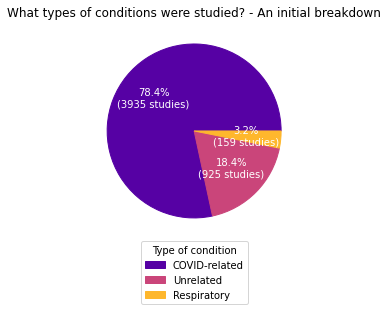

In [11]:
# Visualize the data

condition_detailed_counts = df_studies.study_topic.value_counts()
# print(condition_detailed_counts)

values = condition_detailed_counts.to_numpy()
labels = condition_detailed_counts.keys().to_numpy()

def pctvalue(pct, data):
    counts = int(pct/100 * np.sum(data))
    return "{:.1f}%\n({:d} studies)".format(pct, counts)

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

wedges, texts, autotexts = ax.pie(
    values,
    textprops=dict(color='w'),
    autopct=lambda pct: pctvalue(pct, values)
)

# Colors
def data_color(datalength, mapname='plasma'):
    colours_list = plt.get_cmap(mapname)(np.linspace(0.15,0.84,datalength))
    return colours_list

colours_list = data_color(len(wedges))
for idx, wedge in enumerate(wedges):
    wedge = wedge.set_color(colours_list[idx])

ax.legend(
    wedges, labels,
    title = "Type of condition",
    loc = "center",
    bbox_to_anchor=(0,-0.1, 1,-0.1)
)

ax.set_title("What types of conditions were studied? - An initial breakdown")

plt.show()

# TODO: (BONUS) Make the plot interactive using plotly and enable display of all the raw condition names as listed in the datset


This pie chart shows that almost 78% of the current clinical studies available in the dataset are concerned with SARS-CoV-2 virus or the COVID-19 disease.
However, the **conditions** being studied may not completely represent all studies that are related to COVID.
For this, let's examine the **study titles** to see if the `Unrelated` and `Respiratory` studies contain any COVID-related keywords in their titles.

In [12]:
# Look for the COVID keywords in titles.
titles_unrelated = df_studies[df_studies['study_topic'] == 'Unrelated']['title']
titles_resp = df_studies[df_studies['study_topic'] == 'Respiratory']['title']

sus_titles_id = []

for title in titles_unrelated.append(titles_resp):
    if any(key in title.lower() for key in covid_keys):
        sus_titles_id.append(df_studies.loc[df_studies['title'] == title,'id'].values[0])

ind = df_studies.index[df_studies['id'].isin(sus_titles_id)]
        
# Print some titles
pd.set_option('display.max_colwidth', None)

print('The titles of following studies suggest that they might be related to COVID-19:\n')
df_studies.loc[ind,['id','title','brief_title']].head(7)

# pd.set_option('display.max_colwidth', 40)

The titles of following studies suggest that they might be related to COVID-19:



,id,title,brief_title
22,NCT03042143,"Repair of Acute Respiratory Distress Syndrome by Stromal Cell Administration (REALIST): An Open Label Dose Escalation Phase 1 Trial Followed by a Randomized, Double-blind, Placebo-controlled Phase 2 Trial (COVID-19)",Repair of Acute Respiratory Distress Syndrome by Stromal Cell Administration (REALIST) (COVID-19)
34,NCT03226886,TRACERx Renal (TRAcking Renal Cell Carcinoma Evolution Through Therapy (Rx)) CAPTURE: COVID-19 Antiviral Response in a Pan-tumour Immune Study,TRACERx Renal CAPTURE Sub-study
69,NCT03708718,"A Phase II Randomised Study of Oral Prednisolone in Early Diffuse Cutaneous Systemic Sclerosis (Initially Double-blind, Then Switched to Open-label Because of Covid-19)",Prednisolone in Early Diffuse Systemic Sclerosis
75,NCT03738774,Addressing Post-Intensive Care Syndrome Among Survivors of COVID (APICS-COVID),Addressing Post-Intensive Care Syndrome Among Survivors of COVID (APICS-COVID)
125,NCT04148430,A Phase II Study of IL-1 Receptor Antagonist Anakinra to Prevent Severe Neurotoxicity and Cytokine Release Syndrome in Patients Receiving CD19-Specific Chimeric Antigen Receptor (CAR) T Cells And to Treat Systemic Inflammation Associated With COVID-19,A Study of Anakinra to Prevent or Treat Severe Side Effects for Patients Receiving CAR-T Cell Therapy
155,NCT04255940,Impact of a Novel Coronavirus (2019-nCoV) Outbreak on Public Anxiety and Cardiovascular Disease Risk in China,2019-nCoV Outbreak and Cardiovascular Diseases
156,NCT04256395,Registry Study on the Efficacy of a Self-test and Self-alert Applet in Detecting Susceptible Infection of COVID-19 --a Population Based Mobile Internet Survey,Efficacy of a Self-test and Self-alert Mobile Applet in Detecting Susceptible Infection of COVID-19


As shown here, studies that were not directly concerned with conditions associated with COVID-19 as classified
through `conditions` category were still focused on the secondary impacts of the disease (e.g. "Impact of a Novel Coronavirus (2019-nCoV) Outbreak on Public Anxiety and Cardiovascular Disease Risk in China"). On the other hand, sorting using the `title` column doesn't seem perfect, as it contains some studies whose main focus is irrelevant (e.g. "A Phase II Randomised Study of Oral Prednisolone in Early Diffuse Cutaneous Systemic Sclerosis (Initially Double-blind, Then Switched to Open-label Because of Covid-19)").

Fortunately, it seems that this distinction can be made easily by sorting using the `brief_title` column instead; this makes sense -- in the most concise version of the title, it would be best not to include a minor detail that is irrelevant to the primary focus of the study (such as in the above example where COVID-19 only impacted the type of trial). While this categorization may not be perfect either, for the sake of simplicity I will use this column to sort through the `Unrelated` and `Respiratory` categories. Below are some example titles from doing so.

In [13]:
# Look for the COVID keywords in titles.
brftitles_unrelated = df_studies[df_studies['study_topic'] == 'Unrelated']['brief_title']
brftitles_resp = df_studies[df_studies['study_topic'] == 'Respiratory']['brief_title']

sus_brftitles_id = []

for brftitle in brftitles_unrelated.append(brftitles_resp):
    if any(key in brftitle.lower() for key in covid_keys):
        sus_brftitles_id.append(df_studies.loc[df_studies['brief_title'] == brftitle,'id'].values[0])

ind = df_studies.index[df_studies['id'].isin(sus_brftitles_id)]
        
# Print some titles
pd.set_option('display.max_colwidth', None)

print('The brief titles of following studies suggest that they might be related to COVID-19:\n')
df_studies.loc[ind,['id','title','brief_title']].head(7)

# pd.set_option('display.max_colwidth', 40)

The brief titles of following studies suggest that they might be related to COVID-19:



,id,title,brief_title
22,NCT03042143,"Repair of Acute Respiratory Distress Syndrome by Stromal Cell Administration (REALIST): An Open Label Dose Escalation Phase 1 Trial Followed by a Randomized, Double-blind, Placebo-controlled Phase 2 Trial (COVID-19)",Repair of Acute Respiratory Distress Syndrome by Stromal Cell Administration (REALIST) (COVID-19)
75,NCT03738774,Addressing Post-Intensive Care Syndrome Among Survivors of COVID (APICS-COVID),Addressing Post-Intensive Care Syndrome Among Survivors of COVID (APICS-COVID)
100,NCT03963622,Careful Ventilation in Acute Respiratory Distress Syndrome,Careful Ventilation in Acute Respiratory Distress Syndrome (COVID-19)
155,NCT04255940,Impact of a Novel Coronavirus (2019-nCoV) Outbreak on Public Anxiety and Cardiovascular Disease Risk in China,2019-nCoV Outbreak and Cardiovascular Diseases
156,NCT04256395,Registry Study on the Efficacy of a Self-test and Self-alert Applet in Detecting Susceptible Infection of COVID-19 --a Population Based Mobile Internet Survey,Efficacy of a Self-test and Self-alert Mobile Applet in Detecting Susceptible Infection of COVID-19
159,NCT04260308,"A Survey of Psychological Status of Medical Workers and Residents in the Context of 2019 Novel Coronavirus Pneumonia in Wuhan, China",A Survey of Psychological Status of Medical Workers and Residents in the Context of 2019 Novel Coronavirus Pneumonia
167,NCT04264533,Vitamin C Infusion for the Treatment of Severe 2019-nCoV Infected Pneumonia: a Prospective Randomized Clinical Trial,Vitamin C Infusion for the Treatment of Severe 2019-nCoV Infected Pneumonia


In [14]:
# Label these titles as COVID-related
for brftitle in brftitles_unrelated.append(brftitles_resp):
    if any(key in brftitle.lower() for key in covid_keys):
        df_studies.loc[df_studies['brief_title'] == brftitle,'study_topic'] = 'COVID-related'

What do the remaining titles look like?

In [15]:
# Some titles from studies that are still not classified as being related to COVID

ind = df_studies.index[df_studies['study_topic'].isin(['Unrelated','Respiratory'])]

# Print some titles
pd.set_option('display.max_colwidth', None)

print('There are {} titles that remain unassociated with COVID-19, with samples below:'.format(len(ind)))

df_studies.loc[df_studies['study_topic']=='Respiratory',['id','title','brief_title']].head()

There are 441 titles that remain unassociated with COVID-19, with samples below:


,id,title,brief_title
7,NCT02517489,Effects of Low-dose Corticosteroids on Survival of Severe Community-acquired Pneumonia,Community-Acquired Pneumonia : Evaluation of Corticosteroids
23,NCT03102034,"Phase I Placebo-Controlled Study of the Infectivity, Safety and Immunogenicity of a Single Dose of a Recombinant Live-Attenuated Respiratory Syncytial Virus Vaccine, D46/NS2/N/ΔM2-2-HindIII, Lot RSV#011B, Delivered as Nose Drops to RSV-Seronegative Infants 6 to 24 Months of Age","Evaluating the Infectivity, Safety, and Immunogenicity of a Single Dose of a Recombinant Live-Attenuated Respiratory Syncytial Virus Vaccine (D46/NS2/N/ΔM2-2-HindIII) in RSV-Seronegative Infants 6 to 24 Months of Age"
54,NCT03465280,Airway Intervention Registry (AIR) Extension: Recurrent Respiratory Papillomatosis,Airway Intervention Registry (AIR): Recurrent Respiratory Papillomatosis (RRP)
57,NCT03540706,Impact of the Use of C-reactive Protein in a Micro-method on the Prescription of Antibiotics in General Practitioners Consulting in the Office,Impact of the Use of CRP on the Prescription of Antibiotics in General Practitioners
74,NCT03734237,A Pragmatic Assessment of Influenza Vaccine Effectiveness in the DoD,A Pragmatic Assessment of Influenza Vaccine Effectiveness in the DoD


Now, we can visualize the changes in an updated pie chart.

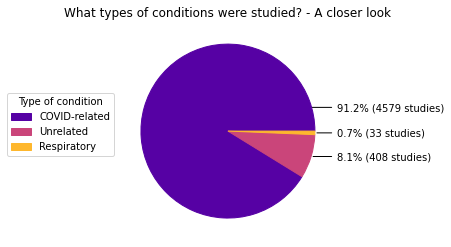

In [16]:
# Re-visualize the above data

condition_detailed_counts = df_studies.study_topic.value_counts()
# print(condition_detailed_counts)

values = condition_detailed_counts.to_numpy()
labels = condition_detailed_counts.keys().to_numpy()

# Get percentage values
def getpct(data):
    pct = data / np.sum(data) * 100
    list_pcts = []
    for idx in range(len(data)):
        list_pcts.append("{:.1f}% ({:d} studies)".format(pct[idx], data[idx]))
    return list_pcts

pcts = getpct(values)

# Plot figure
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
wedges, texts = ax.pie(values)

# Colours
colours_list = data_color(len(wedges))
for idx, wedge in enumerate(wedges):
    wedge.set_color(colours_list[idx])

# Take some labels out of box
bbox_props = dict(boxstyle="square,pad=0.3",
                  fc="1", ec="1", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-",connectionstyle='arc3, rad=0'),
          bbox=bbox_props, zorder=0, va="center", color='k')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ax.annotate(pcts[i], xy=(x, y), xytext=(1.25, y),
                horizontalalignment='left', **kw)

ax.legend(
    wedges, labels,
    title = "Type of condition",
    loc = "best",
    bbox_to_anchor=(-0.1,0.6,0.1,0.1)
)

ax.set_title("What types of conditions were studied? - A closer look")

plt.show()



As shown, COVID-related studies, whether directly or indirectly related, make up a little more than 90% of the trials listed on the [ClinicalTrials.gov](ClinicalTrials.gov) website. Strikingly, only about 1% are study unrelated but respiratory diseases, and about 8% appear to be totally unrelated to COVID-19 (about half as many as in the previous classification). The fact that only a very small percentage of respiratory studies remain unrelated to COVID-19 even after further classification (where 126 studies were merged into the `COVID-related` category) demonstrates that, in many cases, respiratory studies in this dataset may not have set out to focus on COVID-19, but were adjusted to account for it in one way or another.

### Study status
What status is each study currently in? We can start by plotting the `overall_status` column as a simple horizontal bar chart.

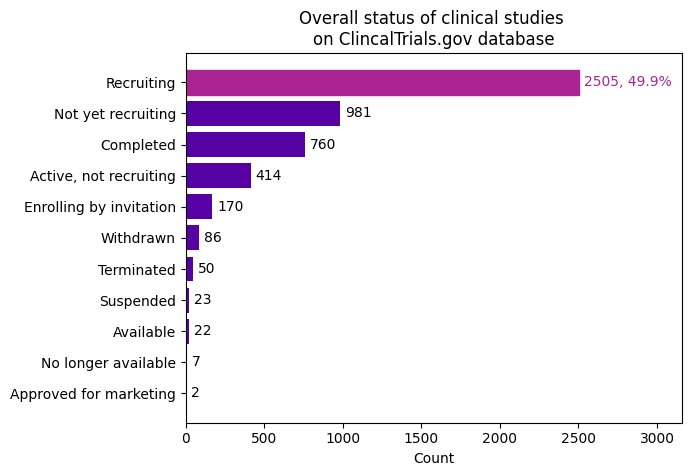

In [17]:
# Define a custom horizontal bar graph

def mybarh_df(catvar, varcounts, colourmap='plasma', xlabel='Count', title='', diffColourIdx=(0,)):
    '''
    Plots a custom horizontal bar graph, each labelled with count numbers. Optionally, you can highlight some bar elements
    differently by defining their indices - this will colour those bars differently and also label them with a percentage
    value of total sum of counts.
    :param catvar: categorical variable to be plotted on the y-axis, array-like
    :param varcounts: x-axis count values of each variable to be plotted, array-like
    :param series: pandas Series object to be used
    :param colourmap: optional, colour map of choice to get colours from; default 'plasma'
    :param xlabel: optional, label of x-axis; default 'Count'
    :param title: optional, title; default empty string
    :param diffColourIdx: optional, indices of bars to highlight;
    :return:
    '''
    plt.rcdefaults()
    fig, ax = plt.subplots()

    colours_list = data_color(4,mapname=colourmap)


    bar_elems = ax.barh(catvar, varcounts, align='center',facecolor=colours_list[0])
    if diffColourIdx != None:
        for idx in diffColourIdx:
            bar_elems[idx].set_color(colours_list[1])

    ax.set_yticks(range(len(catvar)))
    ax.set_yticklabels(catvar)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    _, xmax = plt.xlim()
    if diffColourIdx != None:
        xmax *= 1.2
    else:
        xmax *= 1.1
    plt.xlim(0, xmax)

    for i, c in enumerate(varcounts):
        if (i in diffColourIdx):
            ax.text(c + xmax*0.01, i,
                '{}, {:.1f}%'.format(c, c/np.sum(varcounts)*100),
                color=colours_list[1], ha='left', va='center')
        else:
            ax.text(c + xmax*0.01, i,
                str(c),
                color='black', ha='left', va='center')

    return plt.show()

# Plot
catvar = df_studies['overall_status'].value_counts().index
varcounts = df_studies['overall_status'].value_counts().values

mybarh_df(catvar, varcounts,
           title='Overall status of clinical studies \n'
                'on ClincalTrials.gov database')


In [18]:
pd.set_option('display.max_colwidth', 40)

As shown, almost half of the studies are currently recruiting for participants! It would be interesting to see what proportion of these studies are made up of `COVID-related` ones.

Moreover, while the data in the above chart is sorted in the descending order of counts, the analysis would benefit from grouping these categories for a clearer picture of status distributions across different stages of studies.
Before this grouping is done, I should bring your attention to the fact that the `overall_status` column actually contains information about **recruitment status** as well as **expanded access status**, and they have slightly different implications.

"Recruitment status" is straight forward; it indicates the status that a study is in in terms of participant recruitment, including studies that are not currently recruiting for various possible reasons. On the other hand, "expanded access" refers to a way for patients with serious diseases or conditions who cannot participate in a clinical trial to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA) (see [ClinicalTrials.gov](ClinicalTrials.gov)). Thus, this is a special type of distinction for studies that are already completed. 


Now, in order to group the statuses, we should first study the various status categories. The following are descriptions  study/recruitment statuses, as defined on the website:

| Status | Description |
|:---:|:---|
| Not yet recruiting | The study has not started recruiting participants. |
| Recruiting | The study is currently recruiting participants. |
| Enrolling by invitation | The study is selecting its participants from a population, or group of people, decided on by the researchers in advance. These studies are not open to everyone who meets the eligibility criteria but only to people in that particular population, who are specifically invited to participate. |
| Active, not recruiting | The study is ongoing, and participants are receiving an intervention or being examined, but potential participants are not currently being recruited or enrolled. |
| Suspended | The study has stopped early but may start again. |
| Terminated | The study has stopped early and will not start again. Participants are no longer being examined or treated. |
| Completed | The study has ended normally, and participants are no longer being examined or treated (that is, the last participant's last visit has occurred). |
| Withdrawn | The study stopped early, before enrolling its first participant. |
| Unknown | A study on ClinicalTrials.gov whose last known status was recruiting; not yet recruiting; or active, not recruiting but that has passed its completion date, and the status has not been last verified within the past 2 years. |

While these distinctions provide a detailed portrayal of a study's recruitment status, as mentioned above it may aid our understanding to group them. Here, I'll divide them into four categories based on the stage of study they are in:
`Not started`, `In preparation / Active`, `Inactive`, or `Finished`.


Secondly, the following are descriptions of expanded access statuses; these could altogether be put under their own `Expanded access` group.

| Status | Description |
|:---:|:---|
| Available | Expanded access is currently available for this investigational treatment, and patients who are not participants in the clinical study may be able to gain access to the drug, biologic, or medical device being studied.
| No longer available | Expanded access was available for this intervention previously but is not currently available and will not be available in the future.
| Temporarily not available | Expanded access is not currently available for this intervention but is expected to be available in the future.
| Approved for marketing | The intervention has been approved by the U.S. Food and Drug Administration for use by the public.


 

In [19]:
# TODO: Sort each, and colour each bar according to the groups
df_studies['status_group'] = ['']*len(df_studies.overall_status)
overall_status_list = list(df_studies['overall_status'].value_counts().index)
print(overall_status_list)

['Recruiting', 'Not yet recruiting', 'Completed', 'Active, not recruiting', 'Enrolling by invitation', 'Withdrawn', 'Terminated', 'Suspended', 'Available', 'No longer available', 'Approved for marketing']


In [20]:
# Group the statuses
group_labels = ['Not started', 'In prep / Active', 'Inactive', 'Finished', 'Expanded access']

# TODO: Could refactor this portion; this won't work if the number of studies in each status changes and the
# value count order changes
for i, s in enumerate(overall_status_list):
    if i in [1]:
        idx = 0
    elif i in [0,3,4]:
        idx = 1
    elif i in [5,6,7]:
        idx = 2
    elif i in [2]:
        idx = 3
    elif i in [8,9,10]:
        idx = 4
    elif s == 'Unknown':
        idx = 5
    df_studies.loc[df_studies['overall_status'] == s,'status_group'] = group_labels[idx]

# Create a code for each study topic
df_studies['study_topic_code'] = [''] * len(df_studies['study_topic'])

# Within each group, label the COVID-related ones
df_studies.loc[df_studies.study_topic == 'COVID-related', 'study_topic_code'] = 1
# df_studies.loc[df_studies.study_topic == 'COVID_secondary', 'study_topic_code'] = 1
df_studies.loc[df_studies.study_topic == 'Unrelated', 'study_topic_code'] = 0
df_studies.loc[df_studies.study_topic == 'Respiratory', 'study_topic_code'] = 0

# Sort within each group
grouped_status = df_studies.groupby(['status_group','overall_status','study_topic_code'])['study_topic_code'].agg(len)\
    .unstack()

grouped_status['sum'] = grouped_status.sum(axis=1)

dfs = []
indexList = np.asarray(grouped_status.index.get_level_values(0))

for gr_label in group_labels:
    df = grouped_status.iloc[np.where(indexList==gr_label)[0]].sort_values(by='sum',ascending=False)
    # df['status_group'] = [gr_label]*len(df.index)
    dfs.append(df)

grouped_status = pd.concat(dfs)
del grouped_status['sum']


In [21]:
def mybarh_stacked_df(df, ylabel, title, colToHighlight = 1, colourmap='plasma',
                      xlabel='Count', legendlabel='', cumsum=False):
    '''
    Plots a stacked horizontal bar graph using an unstacked dataframe.
    If dataframe has multiIndex, for the moment this function only supports two levels of multiIndices.
    DataFrame must contain two columns of data, and the second column's data gets highlighted by default unless specified as parameter.
    :param df: dataframe name
    :param ylabel: vertical axis (categorical) label
    :param title: title of plot
    :param colToHighlight: column to highlight; default second column
    :param colourmap: colourmap of choice; default 'plasma'
    :param xlabel: horizontal axis label; default 'count'
    :return: the stacked horizontal bar plot.
    '''

    plt.rcdefaults()
    ax = df.plot.barh( stacked=True, title=title, legend=False)

    categories = df.index
    if isinstance(categories, pd.MultiIndex):
        cat_labels = categories.unique(level=1).to_list()
        cat_groups = categories.unique(level=0).to_list()
    elif isinstance(categories, pd.Index):
        cat_labels = categories.to_list()
        cat_groups = categories.to_list()
    counts = df.values

    # Set axes and labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticklabels(cat_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)

    _, xmax = plt.xlim()
    xmax *= 1.24
    plt.xlim(0, xmax)

    # Colours and formatting
    patches = np.array(ax.patches)
    patches = patches.reshape((2, int(len(patches)/2)))

    colours = data_color(len(cat_groups), colourmap)

    # label the column being highlighted
    for i, c in enumerate(df.sum(axis=1).to_list()):
        # need value itself and the percentage
        value = counts[i,colToHighlight]
        pct = value / np.nansum(counts[i,:]) * 100
        if isinstance(categories, pd.MultiIndex):
            color = colours[cat_groups.index(categories.get_level_values(0)[i])]
        else:
            color = 'black'
        ax.text(c + xmax*0.015, i,
            '{:.0f}, {:.1f}%'.format(value, pct),
            color=color, ha='left', va='center')

    newColourInd = []
    colourInd = -100

    for (idx1,idx2), patch in np.ndenumerate(patches):
        if isinstance(categories, pd.MultiIndex): # update colour as you iterate through groups
            multiIndex_firstLevelVal = categories.get_level_values(0)[idx2]
            colourInd_updated = cat_groups.index(multiIndex_firstLevelVal)
            if colourInd_updated != colourInd:
                newColourInd.append(idx2)
            colourInd = colourInd_updated
        else:
            colourInd = -1

        if idx1 == colToHighlight:
            alpha = 1
        else:
            alpha = 0.5

        patch.set_y( patch.get_y()-0.1 )
        patch.set_height(0.7)
        patch.set_facecolor(colours[colourInd] * alpha)

    if isinstance(categories, pd.MultiIndex):
        ax.legend(patches[colToHighlight,newColourInd],cat_groups,
                  title=categories.names[0].replace('_',' ').capitalize())
    else:
        ax.legend(legendlabel)
    return plt.show()

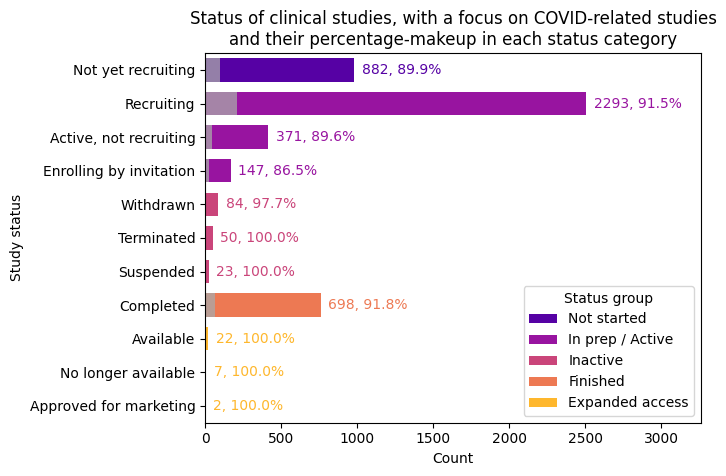

In [22]:
# Plot stacked horizontal bar chart
mybarh_stacked_df(grouped_status, ylabel='Study status',
                  title='Status of clinical studies, with a focus on COVID-related studies\n'
                        'and their percentage-makeup in each status category')

The above chart gives us a more visually clear overview of which stage of study each trial is in. Most studies are currently `In preparation or Active`, with a majority of them by far in `Recruiting` status and almost 92% of those being COVID-19 related.

The second most common status group is `Not started`, where almost 90% of them are COVID-19 related. With scientists all over the world actively trying to better understand the disease, it is not surprising that almost 900 studies have been planned to take place in the future. 

Interestingly, a close third-most common status group is `Completed` containing more than 700 studies, with almost 92% of those COVID-related. I'm curious to learn more about these past and future COVID-related studies through further analysis; for example, what did we learn from completed studies, and will future studies be based on these results? More to follow in Section 3.2!

Finally, the two least common status groups by far are `Inactive` and `Expanded access` groups. In both of these groups, close to 100% of the studies are COVID-related. Based on these, we can reason about two things: one, it is likely rare in normal, pandemic-free contexts for studies to be in either of these status groups; and two, instances for studies to be in `Expanded access` status in particular is likely extremely rare events -- events where circumstances are dire, such as in a novel viral pandemic where lives are at stake.


### Countries of study
In which countries do studies take place? Let's find out.


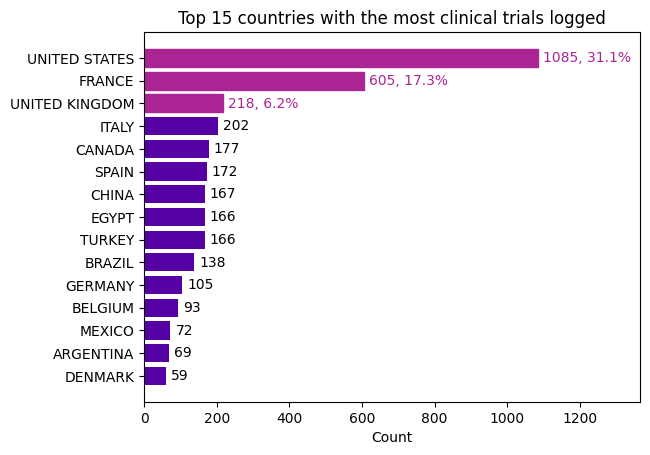

In [23]:
countries = list(df_studies['location_countries'].value_counts().index)
country_counts = list(df_studies['location_countries'].value_counts().values)

mybarh_df(countries[:15], country_counts[:15],
           title='Top 15 countries with the most clinical trials logged',
           diffColourIdx=(0,1,2))


Of the top 15 countries conducting the most clinical trials in the world, United States, France, and United Kingdom each
placed in top three. The percentage values highlighted for these top three countries are percentage values of the total
number of clinical trials conducted by the top 15 countries shown. As can be seen, these three countries' trials make
up about half of the share of clinical trials being conducted by the top 15 countries.

Which of those are COVID-related ones?


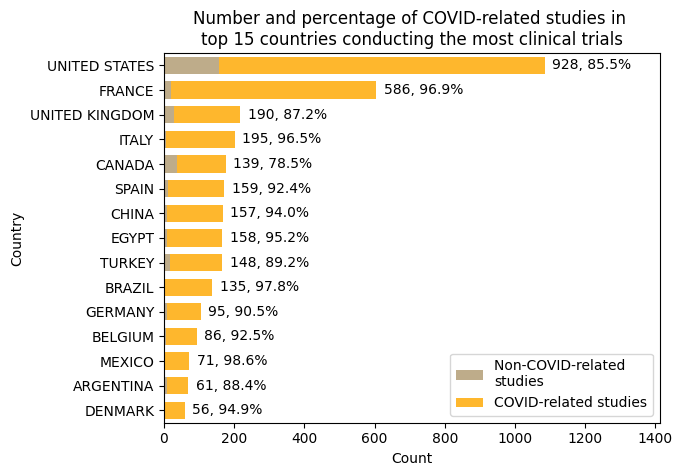

In [24]:
# Horizontal bar graph

# list(df_studies.columns)
# df_studies['location_countries'].value_counts()

# Unstack the countries dataframe
countries = df_studies[['location_countries','study_topic_code']]

# sort rows in a descending order of total number of studies in each country
countries_ind = countries.groupby(['location_countries','study_topic_code']).location_countries.size().unstack()\
    .sum(axis=1).sort_values(ascending=False).index

# Sort using above indices
countries = countries.groupby(['location_countries','study_topic_code']).location_countries.size().unstack().reindex(index=countries_ind)

# countries[:20]
mybarh_stacked_df(countries[:15],
                  ylabel='Country',
                  title='Number and percentage of COVID-related studies in \n'
                        'top 15 countries conducting the most clinical trials',
                  colourmap='plasma',
                  legendlabel=['Non-COVID-related \nstudies', 'COVID-related studies'])

# TODO: Make a stacked bar graph with normalized lengths to highligh the percentage values
# TODO: LEVEL-UP -- draw a world map and graph dots on top of them



As shown here, in all top 15 countries conducting the most clinical trials in the world according to
[ClinicalTrials.gov](https://clinicaltrials.gov), more than 83% of the studies are COVID-related; this demonstrates the
world-wide effort that is being put into researching and learning about the virus and its impact in a variety of ways.



### Study type
What are the study types used? Do COVID-related studies differ from the rest? Before I investigate, the following are definitions of study types included in the dataset, as defined on the website.

#### Interventional studies (also called clinical trials):
A type of clinical study in which participants are assigned to groups that receive one or more intervention/treatment
(or no intervention) so that researchers can evaluate the effects of the interventions on biomedical or health-related
outcomes. The assignments are determined by the study's protocol. Participants may receive diagnostic, therapeutic, or
other types of interventions.

#### Observational studies (includes patient registries):
A type of clinical study in which participants are identified as belonging to study groups and are assessed for
biomedical or health outcomes. Participants may receive diagnostic, therapeutic, or other types of interventions, but
the investigator does not assign participants to a specific interventions/treatment. A patient registry is a type of
observational study.

#### Expanded access:
As described previously.


In [25]:
def mygroupedbar( data, data_labels, group_labels, group_name, data_name='Count', title='', colormap='plasma'):
    '''
    plot grouped data into a bar chart.
    :param data: 2-d array containing columns of different categories. Number of rows should match with length
        of group_labels.
    :param data_labels: labels for data. Length should match with number of columns in data.
    :param data_name: y axis name; default 'Count'
    :param group_labels: labels for groups.
    :param group_name: x axis name.
    :param title: title of plot.
    :return: grouped bar chart.
    '''
    x = np.arange(len(group_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects_grouped = []
    colours_list = data_color(len(group_labels)+1,colormap)

    for col in range(len(data_labels)):
        x_bar_center = x + width/2 * (col*2 - (len(data_labels)-1))
        rects = ax.bar(x_bar_center, data[:,col], width, label=data_labels[col])
        for bar in rects:
            bar.set_color(colours_list[col])
        rects_grouped.append(rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(group_name)
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels)
    ax.set_ylabel(data_name)
    ax.set_ylim([0, ax.get_ylim()[1]*1.1])
    ax.set_title(title)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.0f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    for rects in rects_grouped:
        autolabel(rects)

    fig.tight_layout()

    plt.show()

study_types = df_studies[['study_type','study_topic_code']].groupby(['study_type','study_topic_code']).study_type.agg(len).unstack()

study_types_ind = study_types.index
study_types_new = []

for study_type in study_types_ind:
    study_types_new.append(study_type.replace(' ', '\n'))

data = study_types.fillna(0).values

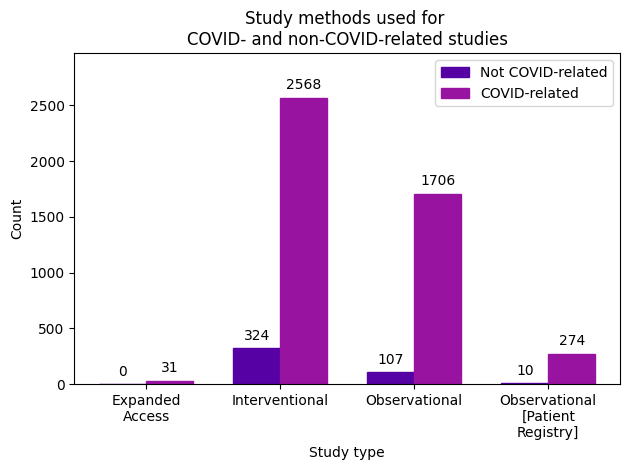

In [26]:
mygroupedbar( data=data, data_labels=['Not COVID-related','COVID-related'],
              data_name='Count', group_labels=study_types_new, group_name='Study type',
              title='Study methods used for \nCOVID- and non-COVID-related studies' )


Both COVID-related and unrelated studies follow a similar trend; in both cases, `Interventional` studies are the most
popular method, `Observational` studies not including patient registry come second, and `Patient registry` come third. Finally, `Expanded access` studies are the rarest of study types, only seen in a minuscule portion of COVID-related studies and not at all in non-COVID-related ones. As reasoned previously, expanded access might be unlikely to be approved, unless urgently necessary such as in the COVID-19 pandemic.


### Enrollment sizes (per study type and per study topic)
What's the distribution of enrollment sizes across different study methods, and across different study types?
Here, I ignore all enrollment sizes that are not available (such as in the Expanded access cases) or zero.


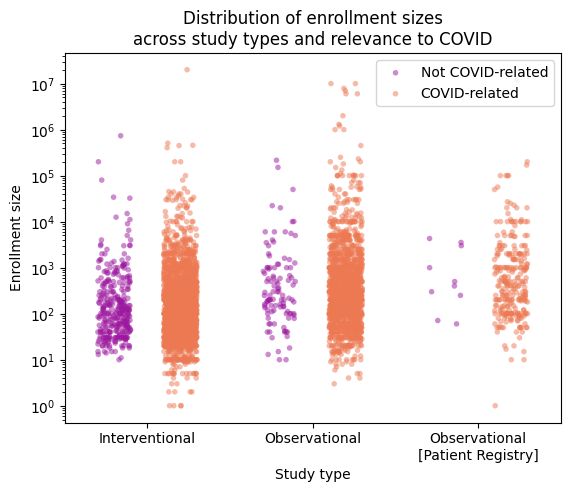

In [27]:
# df_studies.columns
grouper = ['study_type','study_topic_code','enrollment']
enrollments = df_studies[grouper].dropna()
enrollments = enrollments[enrollments['enrollment'] != 0]
study_types_ind_new = study_types_ind[1:].copy()

# plot distributions of enrollment sizes
ax = plt.subplot()
sns.stripplot(
    x='study_type', y='enrollment',
    hue='study_topic_code',
    data=enrollments,
    order=study_types_ind_new,
    dodge=True,
    jitter=0.2,
    size=4, alpha=0.5,
    palette='plasma',
    ax=ax
)
ax.set_yscale('log')
ax.set_ylabel('Enrollment size')
ax.set_xlabel('Study type')
xticklabels = ax.get_xticklabels()
xticklabels[2] = 'Observational\n[Patient Registry]'
ax.set_xticklabels(xticklabels)

ax.legend(['Not COVID-related','COVID-related'])
ax.set_title('Distribution of enrollment sizes\nacross study types and relevance to COVID')

plt.show()

# TODO: Plot a line showing median; use the box plot function?


In [29]:
# Compute statistics
enrollment_dist_stats = []

for study_type in study_types_ind_new:
    data = enrollments.loc[enrollments['study_type']==study_type, ['study_topic_code','enrollment']]
    x = data.loc[data['study_topic_code']==0,'enrollment']
    y = data.loc[data['study_topic_code']==1,'enrollment']

    stat, pval = stats.epps_singleton_2samp(x,y)
    enrollment_dist_stats.append((stat,pval))

for i, statistics in enumerate(enrollment_dist_stats):
    if statistics[1] < 0.05:
        print("For {} studies, COVID-related and non-COVID-related studies' enrollment sizes"
              " came from the same distribution. (p-value = {:.3f}) \n"
              .format(study_types_ind_new[i].lower(),statistics[1]))
    else:
        print("For {} studies, COVID-related and non-COVID-related studies' enrollment sizes"
              " did not come from the same distribution. (p-value = {:.3f}) \n"
              .format(study_types_ind_new[i].lower(),statistics[1]))



For interventional studies, COVID-related and non-COVID-related studies' enrollment sizes did not come from the same distribution. (p-value = 0.515) 

For observational studies, COVID-related and non-COVID-related studies' enrollment sizes did not come from the same distribution. (p-value = 0.940) 

For observational [patient registry] studies, COVID-related and non-COVID-related studies' enrollment sizes came from the same distribution. (p-value = 0.000) 



That's it for now -- stay tuned for Section 3.2 where I will dive deeper into COVID-related studies in the dataset. Thanks for reading!
